# Purpose
The purpose of this Notebook is to learn how to consolidate numerical features from `data/immo_data202208_v2.parquet` in one column each.

# Summary

| Feature       | Complete Data found in/with                                    |
| ------------- | -------------------------------------------------------------- |
| Living Space  | Column `Living_area_unified` or `Space extracted` |
| Rooms         | Merge RegEx from `details_structured` and `No. of rooms:`      |
| Plot Area     | Like in v1 then fillna with `Land area:`                       |
| Floor Space   | Like in v1 then fillna with `Floor space:`                     |
| Floor         | `Floor` then fillna with `floor` from v1                       |
| Price         | Column `price_cleaned`                                         |
| Coordinates   | Columns `Latitude` and `Longitude`                             |

In [126]:
# Import modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [127]:
df = pd.read_parquet(
    "https://github.com/Immobilienrechner-Challenge/data/blob/main/immo_data_202208_v2.parquet?raw=true"
)


# Living Space

In [this](./1-daw_columns.html) notebook we found the following columns contain data on the living space:

- `Living space` (=)
- `Living_area_unified` (new)
- `Living_space_merged` (=)
- `Superficie abitabile` (=)
- `Surface habitable` (=)
- `Surface living:` (new)
- `Wohnfläche` (=)
- `detail_responsive#surface_living` (=)
- `Space extracted` (+8693)

By taking findings from unchanged columns into consideration we can omit some columns for further analysis.

In [128]:
# Select relevant columns
cols_living_space = ["Space extracted", "Living_area_unified", "Surface living:"]
df_living_space = df[cols_living_space]


## NA Heatmap

Like in the v1 analysis we again use a heatmap showing missing values to get an understanding about where the complete data can be found. 

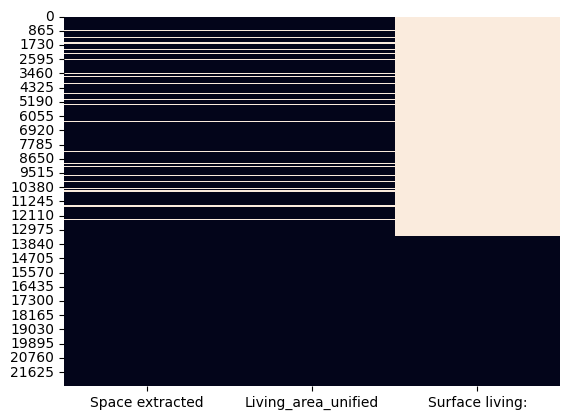

In [129]:
# Sort columns by number of non-null values
df_living_space = df_living_space.reindex(
    df_living_space.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_living_space.isna(), cbar=False)
plt.show()


This suggests that both `Space extracted` and `Living_area_unified` contain the complete dataset. To verify that `Surface living:` does not contain any information that `Living_area_unified` does not we parse and compare the two columns. 

In [130]:
# Parse Surface living: column
df_living_space["Surface living:"] = df_living_space["Surface living:"].str.replace(
    " m²", ""
)
df_living_space["Surface living:"] = df_living_space["Surface living:"].str.replace(
    " m2", ""
)
df_living_space["Surface living:"] = df_living_space["Surface living:"].astype(float)


In [131]:
# check if contents of "Surface living:" are the same as "Living_area_unified"
(
    df_living_space["Surface living:"] == df_living_space["Living_area_unified"]
).sum() == df_living_space["Surface living:"].count()


True

This count equals the number of rows added in this version of the dataset, so we can confirm that the column `Living_area_unified` contains all information present in `Surface living:` making it useless.

In [132]:
df_living_space.drop(["Surface living:"], axis=1, inplace=True)


We now compare the data in the two remaining columns to see if there's any difference. 

In [133]:
# Display rows where "Space extracted" is not null and "Living_area_unified" is null
df_living_space[
    df_living_space["Space extracted"].notna()
    & df_living_space["Living_area_unified"].isna()
]


,Space extracted,Living_area_unified


In [134]:
# Display rows where "Space extracted" is null and "Living_area_unified" is not null
df_living_space[
    df_living_space["Space extracted"].isna()
    & df_living_space["Living_area_unified"].notna()
]


,Space extracted,Living_area_unified


In [135]:
# Display rows where "Space extracted" is not equal to "Living_area_unified"
df_living_space[
    df_living_space["Space extracted"].fillna("")
    != df_living_space["Living_area_unified"].fillna("")
]


,Space extracted,Living_area_unified


In [136]:
# Check if all rows are equal
(
    df_living_space["Space extracted"].fillna("")
    == df_living_space["Living_area_unified"].fillna("")
).sum() == df_living_space.shape[0]


True

The above comparisons show that all rows of the two columns are equal so we can use either column for the living space.

In [137]:
df_living_space.describe()


,Space extracted,Living_area_unified
count,20979.000000,20979.000000
mean,160.777253,160.777253
std,136.126762,136.126762
min,1.000000,1.000000
25%,96.000000,96.000000
50%,130.000000,130.000000
75%,181.000000,181.000000
max,4362.000000,4362.000000


# Rooms
We shown that the following columns contain information on the feature rooms:

- `No. of rooms:` (new)
- `rooms` (+8868)
- `details_structured`

In [138]:
# Select relevant columns
cols_rooms = ["rooms", "No. of rooms:"]
df_rooms = df[cols_rooms]

df_rooms["from_details_structured"] = df.loc[
    df["provider"] == "Immoscout24.ch", "details_structured"
].str.extract(r"(\d+\.?\d?) rooms")


## NA Heatmap

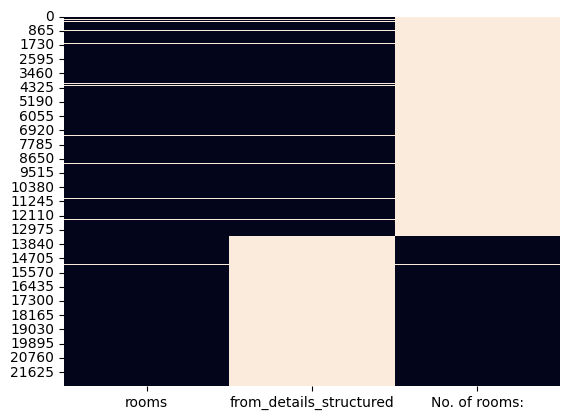

In [139]:
# Sort columns by number of non-null values
df_rooms = df_rooms.reindex(df_rooms.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_rooms.isna(), cbar=False)
plt.show()


In the [previous version](../../v1/exports/3-daw_quantitative.html) of this analysis we found that the column `rooms` didn't contain the correct data. 

In [140]:
df_rooms["rooms"].count()


21646

In [141]:
df_rooms["rooms"].value_counts()


5.0       10916
4.5rm      2179
3.5rm      1624
5.5rm      1116
2.5rm       781
6.5rm       451
6rm         345
6.0         344
7.0         309
5rm         283
7rm         259
4.0         250
4rm         248
8.0         239
3.0         200
7.5rm       198
8rm         191
1.5rm       163
3rm         156
2.0         152
9.0         140
0.0         138
9rm         134
10rm        110
8.5rm       100
1.0          90
2rm          89
1rm          85
12rm         73
11rm         60
9.5rm        51
14rm         25
15rm         21
13rm         19
10.5rm       16
20rm         15
11.5rm        9
18rm          9
12.5rm        8
17rm          6
19rm          5
16rm          5
23rm          4
14.5rm        4
15.5rm        3
16.5rm        3
13.5rm        3
24rm          2
17.5rm        2
19.5rm        2
22rm          2
21rm          1
28.5rm        1
24.5rm        1
33rm          1
25rm          1
30rm          1
35rm          1
18.5rm        1
26rm          1
Name: rooms, dtype: int64

New data in the column `rooms` appear to have a suffix and the above output shows that all values without the «rm» suffix do not contain .5 values which is why we prefer not to use this column.

In [142]:
df_rooms.drop("rooms", axis=1, inplace=True)


To get the more accurate we can merge the two remaining columns.

In [143]:
# Merge from_details_structured and No. of rooms:
df_rooms["rooms"] = df_rooms["from_details_structured"].fillna(
    df_rooms["No. of rooms:"]
)


In [144]:
df_rooms["rooms"].value_counts()


4.5     3469
3.5     2312
5.5     2183
4.5     2179
3.5     1624
        ... 
21.0       1
28.5       1
29         1
22         1
26.0       1
Name: rooms, Length: 92, dtype: int64

In [145]:
df_rooms["rooms"].count()


21647

And we can see that the count of the merged column even contains one more observation

In [146]:
df_rooms.describe()


,No. of rooms:
count,8868.000000
mean,5.039693
std,2.508945
min,1.000000
25%,3.500000
50%,4.500000
75%,5.500000
max,35.000000


# Plot Area
Data on the plot area is contained in the following columns:

- `Land area:` (new)
- `Plot_area_merged` (=)
- `Plot_area_unified` (new)
- `detail_responsive#surface_property` (=)

In [147]:
# Select relevant columns
cols_plot_area = ["Land area:", "Plot_area_unified"]
df_plot_area = df[cols_plot_area]

# Merge and extract Plot_area_merged and detail_responsive#surface_property as in v1
df_plot_area["plot_area"] = df["Plot_area_merged"].fillna(
    df["detail_responsive#surface_property"]
)
df_plot_area["plot_area"] = df_plot_area["plot_area"].str.extract("(\d+,?\d*)")


## NA Heatmap

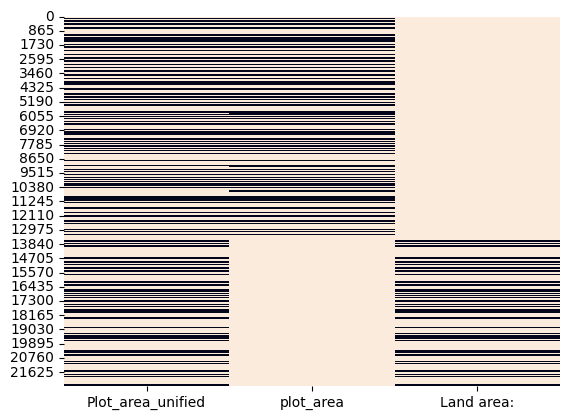

In [148]:
# Sort columns by number of non-null values
df_plot_area = df_plot_area.reindex(
    df_plot_area.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_plot_area.isna(), cbar=False)
plt.show()


Based on this heatmap we can observe that the merged `plot_area` column does contain more information in the top part of the data than `Plot_area_unified`. Merged together with `Land area:` this should give us the most complete data.

In [149]:
# Merge plot_area with Land area:
df_plot_area["plot_area"] = df_plot_area["plot_area"].fillna(df_plot_area["Land area:"])

# Parse plot_area
df_plot_area["plot_area"] = df_plot_area["plot_area"].str.extract("(\d+,?\d*)")
df_plot_area["plot_area"] = df_plot_area["plot_area"].str.replace(",", "").astype(float)


In [150]:
df_plot_area["plot_area"].count()


8210

In [151]:
df_plot_area["Plot_area_unified"].count()


7953

In [152]:
# Show where plot_area and Plot_area_unified are equal
(df_plot_area["plot_area"] == df_plot_area["Plot_area_unified"]).sum()


7953

This above comparison proves that all rows of `Plot_area_unified` are contained in the data of the merged `plot_area`.

In [153]:
df_plot_area.drop("Plot_area_unified", axis=1, inplace=True)


In [154]:
df_plot_area.describe()


,plot_area
count,8210.000000
mean,1377.371498
std,6616.783615
min,1.000000
25%,347.250000
50%,646.000000
75%,1137.000000
max,350917.000000


# Floor Space
We found that the following columns contain relevant information on the floor space:

- `Floor space:` (new)
- `Floor_space_merged` (=)
- `detail_responsive#surface_usable` (=) 

In [155]:
# Select relevant columns
cols_floor_space = ["Floor space:"]
df_floor_space = df[cols_floor_space]

# Merge and extract Floor_space_merged and detail_responsive#surface_usable as in v1
df_floor_space["floor_space"] = df["Floor_space_merged"].fillna(
    df["detail_responsive#surface_usable"]
)
df_floor_space["floor_space"] = (
    df_floor_space["floor_space"].replace("", np.nan).str.extract("(\d+,?\d*)")
)


## NA Heatmap

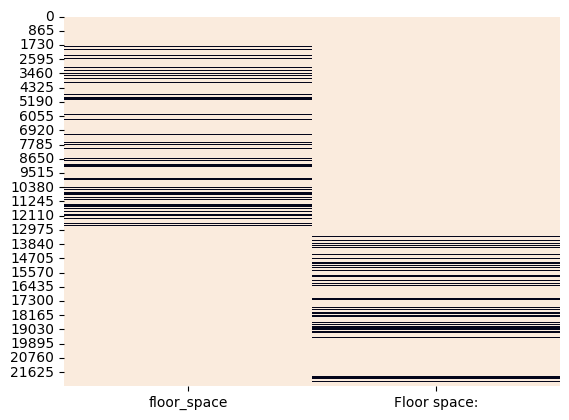

In [156]:
# Sort columns by number of non-null values
df_floor_space = df_floor_space.reindex(
    df_floor_space.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_floor_space.isna(), cbar=False)
plt.show()


This visualisation makes it clear that we get the full data by merging `floor_space` and `Floor space:`.

In [157]:
# Merge floor_space with Floor space:
df_floor_space["floor_space"] = df_floor_space["floor_space"].fillna(
    df_floor_space["Floor space:"]
)

# Parse floor_space
df_floor_space["floor_space"] = df_floor_space["floor_space"].str.extract("(\d+,?\d*)")
df_floor_space["floor_space"] = (
    df_floor_space["floor_space"].str.replace(",", "").astype(float)
)


In [158]:
df_floor_space.drop("Floor space:", axis=1, inplace=True)


In [159]:
df_floor_space.describe()


,floor_space
count,5708.000000
mean,201.049580
std,249.021012
min,1.000000
25%,101.000000
50%,148.000000
75%,234.000000
max,7798.000000


# Floor
We found that the following columns contain relevant data on the floor of an object:

- `Floor` (+4636)
- `Floor_merged` (=)
- `Floor_unified` (new)
- `detail_responsive#floor` (=)

In [160]:
# Select relevant columns
cols_floor = ["Floor", "Floor_unified"]
df_floor = df[cols_floor]

# Merge Floor_merged and detail_responsive#floor as in v1
df_floor["floor"] = df["Floor_merged"].fillna(df["detail_responsive#floor"])


## NA Heatmap

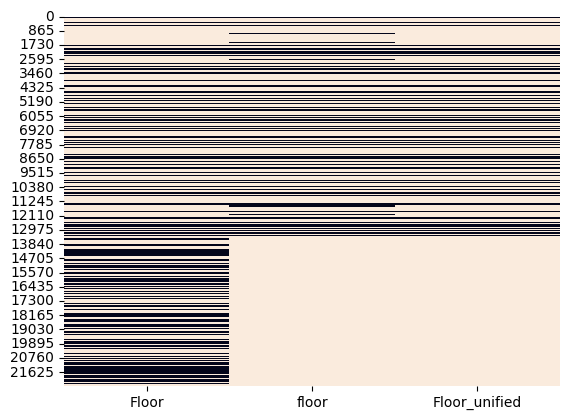

In [161]:
# Sort columns by number of non-null values
df_floor = df_floor.reindex(df_floor.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_floor.isna(), cbar=False)
plt.show()


Based on this output we can see that `floor` contains information where `Floor` does not. Also that `Floor_unified` does not contain the complete data. 

In [162]:
# Sum rows where Floor and floor are not equal
(
    df_floor[df_floor["Floor"].notna() & df_floor["floor"].notna()]["Floor"]
    != df_floor[df_floor["Floor"].notna() & df_floor["floor"].notna()]["floor"]
).sum()


0

Since the values of `Floor` and `floor` are equal where they are not na we decided to fill the na values in `Floor` with the data from `floor`.

In [163]:
# Fill Floor with floor
df_floor["Floor"] = df_floor["Floor"].fillna(df_floor["floor"])


In [164]:
df_floor["Floor"].value_counts()


1. floor        1747
Ground floor    1388
1               1332
2. floor        1326
GF              1191
2               1032
3. floor         693
3                597
4. floor         265
4                249
5. floor          91
5                 84
6                 45
6. floor          39
7                 25
999               23
7. floor          20
8                 16
-1                13
10                12
8. floor           6
9                  5
2. Basement        5
999. floor         5
11                 4
10. floor          4
9. floor           4
11. floor          3
12                 3
12. floor          3
1. Basement        3
23                 2
14. floor          2
23. floor          2
-3                 1
-2                 1
195                1
24                 1
-4                 1
13                 1
3. Basement        1
16                 1
20                 1
1011               1
15. floor          1
4. Basement        1
100. floor         1
21. floor    

In [165]:
df_floor.drop(["floor", "Floor_unified"], axis=1, inplace=True)


In [166]:
df_floor.describe()


,Floor
count,10255
unique,50
top,1. floor
freq,1747


# Price
We found that the following columns contain relevant information on the price of an object:

- `price` (+9126)
- `price_cleaned` (+9126)
- `price_s` (new)

In [167]:
# Select relevant columns
cols_price = ["price", "price_cleaned", "price_s"]
df_price = df[cols_price]


## NA Heatmap

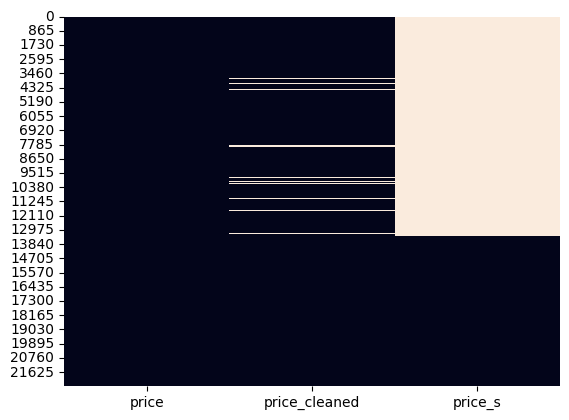

In [168]:
# Sort columns by number of non-null values
df_price = df_price.reindex(df_price.count().sort_values(ascending=False).index, axis=1)

# Create isna heatmap
sns.heatmap(df_price.isna(), cbar=False)
plt.show()


In [v1 of the analysis](../../v1/exports/3-daw_quantitative.html) we've shown that the column `price` contains hidden na values and less data on the price than `price_cleaned`.

In [169]:
df_price["price"].value_counts()


Price on request    1015
CHF 1,250,000.—      145
CHF 890,000.—        139
CHF 850,000.—        135
CHF 790,000.—        125
                    ... 
CHF 469,900.—          1
CHF1,930,000.–         1
CHF 718,000.—          1
CHF1,945,000.–         1
CHF1,088,888.–         1
Name: price, Length: 2681, dtype: int64

This seems to be still the case so we'll focus on the `price_cleaned` column again.

In [170]:
df_price["price"] = (
    df_price["price"]
    .str.extract("CHF ([\d,]+)")
    .replace(",", "", regex=True)
    .astype(float)
)
df_price["price"].count() - df_price["price_cleaned"].count()


-9133

We still get more data in the column `price_cleaned`, so we'll use it going forward.

In [171]:
df_price.drop(["price", "price_s"], axis=1, inplace=True)


In [172]:
df_price.describe()


,price_cleaned
count,2.146600e+04
mean,1.302068e+06
std,1.704596e+06
min,1.000000e+00
25%,5.750000e+05
50%,8.600000e+05
75%,1.418000e+06
max,4.900000e+07


# Coordinates
The following columns contain relevant information on the coordinates:

- `Latitude` (+9126)
- `lat` (+9126)
- `Longitude` (+9126)
- `lon`(9126)

In [173]:
# Select relevant columns
cols_coordinates = ["lat", "lon", "Latitude", "Longitude"]
df_coordinates = df[cols_coordinates]


In [174]:
# Get number of isnull values
df_coordinates.isnull().sum()


lat          17
lon          17
Latitude      0
Longitude     0
dtype: int64

In [175]:
# Get all rows with isnull values
df_coordinates[df_coordinates.isnull().any(axis=1)]


,lat,lon,Latitude,Longitude
3851,NaN,NaN,47.483776,8.766671
4073,NaN,NaN,47.483776,8.766671
4074,NaN,NaN,47.483776,8.766671
4075,NaN,NaN,47.483776,8.766671
4203,NaN,NaN,47.483776,8.766671
4206,NaN,NaN,47.483776,8.766671
4209,NaN,NaN,47.483776,8.766671
4212,NaN,NaN,47.483776,8.766671
10211,NaN,NaN,47.483776,8.766671
10214,NaN,NaN,47.483776,8.766671


With this we again conclude that the columns `Latitude` and `Longitude` contain the most complete data on the coordinates.